# #Masks Throughout COVID-19: A Twitter Sentiment Analysis

## Natural Language Processing, Feature Engineering, and Data Exploration

## Table of contents
1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Answering the initial questions](#Step-1:-Answering-the-initial-questions)
5. [Step 2: Checking the data](#Step-2:-Checking-the-data)
6. [Step 3: Cleaning the data](#Step-3:-Cleaning-the-data)
7. [Step 4: Exploratory analysis and feature engineering](#Step-4:-Exploratory-analysis-and-feature-engineering)

    - [Dummy columns](#Dummy-columns)
    - [Vanilla models interruption](#Vanilla-models-interruption)
    - [Finishing dummy columns](#Finishing-dummy-columns)


8. [Step 5: Modeling](#Step-5:-Modeling)

    - [Cross-validation](#Cross-validation)
    - [Parameter tuning](#Parameter-tuning)


9. [Step 6: Reproducibility](#Step-6:-Reproducibility)
10. [Conclusions](#Conclusions)
11. [Acknowledgements](#Acknowledgements)

## Introduction
[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

After scraping Twitter with [twint](https://github.com/twintproject/twint), we will use natural language processing (NLP) techniques to analyze the sentiment of tweets relating to masks and coronavirus.

Through text processing, exploratory data analysis and feature engineering, we will look for insights into how important words, topics, and subjectivity relate to sentiment.

We will then create predictive models that classify tweets as *negative*, *neutral*, or *positive*. This will help us provide further insight and confirm our findings during EDA. *(NOTE: To skip to the modeling notebook, click [here](04_modeling_notebook.ipynb))*.

## The problem domain
[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

The New York City Department of Parks and Recreation would like to use its current data to bolster or modify their environmental policy agenda while also looking for ways to improve their data collection for the next tree census in 2025. There is also some interest within the department to compare data collected by professional staff (members of the Parks Department and TreesCount) with that collected by volunteers. 

The department has tasked me with the following:

- Identify factors that contribute to the health status of a tree.
- Create suggestions for improving future censuses.
- Build a model that can predict a tree's health status, to verify the status determined by volunteers.

## Required libraries
[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **NumPy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **SciPy**: The essential statistical analysis package in Python.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **Seaborn**: Advanced statistical plotting library.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **GeoPandas**: Provides a specialized GeoDataFrame structure to more easily analyze locational data.
- **functions**: Custom functions that I built for this project (included by cloning this project's repo).

Run the cell below to import all of the necessary libraries.

In [1]:
# standard libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing/nlp libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
from collections import Counter

# saving libraries
import gzip
import pickle

# custom functions
from functions import *

# reload when functions is edited
%load_ext autoreload
%autoreload 2

In [2]:
# increase column width to more easily read tweets
pd.set_option('max_colwidth', 150)

# Loading csv

In [3]:
# load file
df = pd.read_csv('data/jan_thru_may_5k_tweets_clean.csv', index_col=0)

# convert date column to datetime
df['date'] = df.date.astype('datetime64[ns]')

# check shape
df.shape

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(575949, 17)

In [4]:
df.head()

,id,conversation_id,created_at,date,tweet,hashtags,user_id,username,name,link,retweet,nlikes,nreplies,nretweets,quote_url,retweet_id,reply_to
0,1.212523e+18,1.212523e+18,1.577923e+12,2020-01-01,"https://mltshp.com/p/1HLSB ""This is the death mask of Thomas, an unknown peasant that died in a river.""",[],8.431951e+17,Best_of_MLTSHP,MLTSHP,https://twitter.com/Best_of_MLTSHP/status/1212523477896294400,False,1.0,0.0,1.0,NaN,NaN,"[{'user_id': '843195118924546048', 'username': 'Best_of_MLTSHP'}]"
1,1.212518e+18,1.212518e+18,1.577922e+12,2020-01-01,Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...,[],1.044739e+18,lumora_lu,MiLu,https://twitter.com/lumora_lu/status/1212518043353530368,False,0.0,0.0,0.0,NaN,NaN,"[{'user_id': '1044738746913034241', 'username': 'lumora_lu'}]"
2,1.212518e+18,1.212518e+18,1.577922e+12,2020-01-01,"We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...","['#ccpchina', '#sars', '#hk', '#hkers']",9.630325e+17,odiecher,odiecher,https://twitter.com/odiecher/status/1212517557690748928,False,1.0,1.0,1.0,https://twitter.com/WBYeats1865/status/1212430526826479616,NaN,"[{'user_id': '963032516759207936', 'username': 'odiecher'}]"
3,1.212516e+18,1.200523e+18,1.577921e+12,2020-01-01,Thought death masks gave you the horn freak,[],2.819219e+09,Hevysmoker,Ashley Collins,https://twitter.com/Hevysmoker/status/1212515585562726401,False,0.0,0.0,0.0,NaN,NaN,"[{'user_id': '2819219369', 'username': 'Hevysmoker'}, {'user_id': '1107018506300780544', 'username': 'cutedeadguys3'}]"
4,1.212510e+18,1.212391e+18,1.577920e+12,2020-01-01,"Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐",[],2.361956e+08,FaithR8s,❌Patriot Fan🇺🇸🗽☕️🎶❌,https://twitter.com/FaithR8s/status/1212510409858670593,False,1.0,0.0,1.0,NaN,NaN,"[{'user_id': '236195607', 'username': 'FaithR8s'}, {'user_id': '14745988', 'username': 'ThunderB'}, {'user_id': '14138785', 'username': 'Telegraph..."


### Drop unnecessary columns

In [5]:
# drop columns we know we won't need for this project
df.drop(columns=['id', 'conversation_id', 'created_at', 'hashtags', 'user_id', 'name',
                 'retweet', 'quote_url', 'retweet_id', 'reply_to'], inplace=True)

# check
df.shape

(575949, 7)

In [6]:
df.head()

,date,tweet,username,link,nlikes,nreplies,nretweets
0,2020-01-01,"https://mltshp.com/p/1HLSB ""This is the death mask of Thomas, an unknown peasant that died in a river.""",Best_of_MLTSHP,https://twitter.com/Best_of_MLTSHP/status/1212523477896294400,1.0,0.0,1.0
1,2020-01-01,Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...,lumora_lu,https://twitter.com/lumora_lu/status/1212518043353530368,0.0,0.0,0.0
2,2020-01-01,"We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...",odiecher,https://twitter.com/odiecher/status/1212517557690748928,1.0,1.0,1.0
3,2020-01-01,Thought death masks gave you the horn freak,Hevysmoker,https://twitter.com/Hevysmoker/status/1212515585562726401,0.0,0.0,0.0
4,2020-01-01,"Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐",FaithR8s,https://twitter.com/FaithR8s/status/1212510409858670593,1.0,0.0,1.0


### Obtaining target variable

In [7]:
# instantiate Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score
df['sentiment_score'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [8]:
# turn this into our target classes: negative, positive, and neutral
conditions = [
    df.sentiment_score >= .05,
    df.sentiment_score <= -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment'] = np.select(conditions, choices, 'neutral')

- **Take a look at our target variable.**

In [9]:
df.sentiment.value_counts()

positive    239222
negative    221377
neutral     115350
Name: sentiment, dtype: int64

In [10]:
df.sentiment.value_counts(normalize=True)

positive    0.415353
negative    0.384369
neutral     0.200278
Name: sentiment, dtype: float64

In [11]:
# uncomment to save
df.to_csv('data/5k_jan_thru_may_tweets.csv')

## Load file with sentiment

In [12]:
# uncomment to load
df = pd.read_csv('data/5k_jan_thru_may_tweets.csv', index_col=0)

# convert date column to datetime
df['date'] = df.date.astype('datetime64[ns]')

df.shape

(575949, 9)

## Cleaning text
- **Start with NLTK stopwords and add our own subject-specific ones.**

In [13]:
# start with NLTK stop words
stop_words = stopwords.words('english')

# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']

# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people', 'us', 'like', 'n95',
                  'go', 'going', 'would', 'surgical', 'via', 'also', 'use', 'even', 'know']

stop_words += eda_stop_words

### Create clean tweet column with our clean_text function
- **Also save as a series, because that'll be helpful later on.**

In [14]:
%time df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# pull the clean tweet column
clean_tweets = df['clean_tweet']
clean_tweets.head()

CPU times: user 6min 39s, sys: 1.46 s, total: 6min 41s
Wall time: 6min 43s


0                                                                                                                  death thomas unknown peasant died river
1                                                    ready heard homemade hair treatment ann cherry dead sea mud fucking putas swear woman bitch shut fuck
2    joke #ccpchina come epidemic outbreakthink stayed silent #sars dear worldstay away #hk im sure infected amongst already dear fellow #hkers facewit...
3                                                                                                                            thought death gave horn freak
4                                                              interesting cult death thinkingface electronically posing cia brennan chief facewithmonocle
Name: clean_tweet, dtype: object

In [15]:
df.isna().sum()

date               0
tweet              0
username           0
link               0
nlikes             0
nreplies           0
nretweets          0
sentiment_score    0
sentiment          0
clean_tweet        0
dtype: int64

##### Save to pickle

In [17]:
# # uncomment to save
# clean_tweets.to_pickle('data/clean_tweets.pkl')

# # uncomment to load
# clean_tweets = pd.read_pickle('data/clean_tweets.pkl')

## Sparse vector matrix
- **Our main features, which we will also use for LDA topic modeling.**

In [ ]:
# regex pattern to vectorize by
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-zx]+)?)"

In [ ]:
# create a document-term matrix using TfidfVectorizer, using custom regex tokenizing pattern
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)
%time data_tf_idf = tf_idf.fit_transform(clean_tweets)

# save as a DataFrame
data_vec = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())
data_vec.head()

In [ ]:
data_vec.shape

In [20]:
# # uncomment to save
# with gzip.open('data/data_vec.pkl', 'wb') as goodbye:
#     pickle.dump(data_vec, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# uncomment to load
with gzip.open('data/data_vec.pkl', 'rb') as hello:
    data_vec = pickle.load(hello)

## LDA topic modeling
#### PLEASE NOTE: These are not our original topics. Unfortunately we lost those (except for a screenshot, which resides in our Images folder); we used those original topics for our presentation.

In [21]:
%%time

# one of the required inputs is a term-document matrix
tdm = data_vec.transpose()
tdm.head()

# put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
# TAKES A FEW MINUTES
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

# gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in tf_idf.vocabulary_.items())

NameError: name 'tf_idf' is not defined

###### Pickle the gensim corpus and vocab locations

In [ ]:
# # uncomment to save
# with gzip.open('data/gensim_corpus.pkl', 'wb') as c:
#     pickle.dump(corpus, c, protocol=pickle.HIGHEST_PROTOCOL)
    
# with gzip.open('data/gensim_id2word.pkl', 'wb') as i:
#     pickle.dump(id2word, i, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# # uncomment to load
# with gzip.open('gensim_corpus.pkl', 'rb') as c:
#     corpus = pickle.load(c)
    
# with gzip.open('gensim_id2word.pkl', 'rb') as i:
#     id2word = pickle.load(i)

- **Use corpus and dictionary of term locations.**
- **Set number of topics and passes to create an LDA model.**
    - **NOTE: Uncomment next cell to run. Takes a few hours!**

In [53]:
# %%time

# # create the topics
# lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=100, iterations=100)

# # view the topics
lda.print_topics()

[(0,
  '0.009*"protest" + 0.007*"facewithtearsofjoy" + 0.007*"think" + 0.007*"still" + 0.006*"want" + 0.006*"riot" + 0.006*"see" + 0.006*"got" + 0.005*"make" + 0.005*"without"'),
 (1,
  '0.013*"facewithmedicalmask" + 0.011*"county" + 0.011*"weekend" + 0.010*"design" + 0.010*"#health" + 0.010*"thinkingface" + 0.010*"shirt" + 0.009*"#sale" + 0.009*"period" + 0.009*"forgot"'),
 (2,
  '0.015*"business" + 0.011*"healthy" + 0.010*"#socialdistancing" + 0.009*"need" + 0.009*"taking" + 0.009*"biden" + 0.008*"care" + 0.008*"person" + 0.008*"u" + 0.007*"hide"'),
 (3,
  '0.014*"spread" + 0.013*"protect" + 0.011*"transmission" + 0.011*"distance" + 0.010*"safe" + 0.010*"cloth" + 0.010*"stay" + 0.010*"others" + 0.009*"prevent" + 0.008*"help"'),
 (4,
  '0.022*"pandemic" + 0.013*"fauci" + 0.012*"reduce" + 0.011*"wave" + 0.010*"guidance" + 0.010*"healthy" + 0.010*"#staysafe" + 0.009*"spread" + 0.009*"rule" + 0.008*"patient"'),
 (5,
  '0.013*"lockdown" + 0.009*"mandatory" + 0.009*"#pandemic" + 0.009*"wor

### Save/Load LDA model

In [18]:
# # uncomment to save
# with gzip.open('models/lda_10topics_100passes.pkl', 'wb') as goodbye:
#     pickle.dump(lda, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# uncomment to load
with gzip.open('models/lda_10topics_100passes.pkl', 'rb') as hello:
    lda = pickle.load(hello)

- **Assign each tweet to the topic to which it most closely fits.**

In [22]:
# corpus from LDA model
corpus_transformed = lda[corpus]

# confirm size
len(corpus_transformed)

575949

In [23]:
# check out an example
corpus_transformed[0]

[(0, 0.03400737),
 (1, 0.03400346),
 (2, 0.034003943),
 (3, 0.034011845),
 (4, 0.03400346),
 (5, 0.034005884),
 (6, 0.03400346),
 (7, 0.24029602),
 (8, 0.03400346),
 (9, 0.4876611)]

In [24]:
%%time

# obtain the topic that a resembles the tweet most
topics = [lda_getter(x) for x in corpus_transformed]

# confirm shape
len(topics)

575949

In [25]:
# check out an example
topics[:10]

[9, 0, 0, 0, 4, 7, 0, 1, 7, 2]

In [26]:
# turn list into dataframe column
df['lda_topic_max'] = topics
df['lda_topic_max'].head()

0    9
1    0
2    0
3    0
4    4
Name: lda_topic_max, dtype: int64

In [27]:
# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# confirm
lda_topics_dict[0]

{0: 0.034007363,
 1: 0.03400346,
 2: 0.034003936,
 3: 0.03401156,
 4: 0.03400346,
 5: 0.03400588,
 6: 0.03400346,
 7: 0.24029599,
 8: 0.03400346,
 9: 0.48766148}

In [28]:
# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# check it out
lda_df.head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9
0,0.034007,0.034003,0.034004,0.034012,0.034003,0.034006,0.034003,0.240296,0.034003,0.487661
1,0.663231,0.021874,0.021892,0.021897,0.021906,0.084468,0.021876,0.099109,0.021873,0.021874
2,0.685745,0.020862,0.020866,0.020862,0.020862,0.081748,0.020860,0.086471,0.020860,0.020863
3,0.475635,0.033897,0.033904,0.033899,0.033897,0.033902,0.033897,0.033901,0.253149,0.033919
4,0.029398,0.259405,0.029399,0.029394,0.411632,0.029402,0.029414,0.029392,0.029392,0.123171


In [29]:
df = pd.concat([df, lda_df], axis=1)
df.head()

,date,tweet,username,link,nlikes,nreplies,nretweets,sentiment_score,sentiment,clean_tweet,...,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9
0,2020-01-01,"https://mltshp.com/p/1HLSB ""This is the death mask of Thomas, an unknown peasant that died in a river.""",Best_of_MLTSHP,https://twitter.com/Best_of_MLTSHP/status/1212523477896294400,1.0,0.0,1.0,-0.8176,negative,death thomas unknown peasant died river,...,0.034007,0.034003,0.034004,0.034012,0.034003,0.034006,0.034003,0.240296,0.034003,0.487661
1,2020-01-01,Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...,lumora_lu,https://twitter.com/lumora_lu/status/1212518043353530368,0.0,0.0,0.0,-0.8905,negative,ready heard homemade hair treatment ann cherry dead sea mud fucking putas swear woman bitch shut fuck,...,0.663231,0.021874,0.021892,0.021897,0.021906,0.084468,0.021876,0.099109,0.021873,0.021874
2,2020-01-01,"We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...",odiecher,https://twitter.com/odiecher/status/1212517557690748928,1.0,1.0,1.0,0.6705,positive,joke #ccpchina come epidemic outbreakthink stayed silent #sars dear worldstay away #hk im sure infected amongst already dear fellow #hkers facewit...,...,0.685745,0.020862,0.020866,0.020862,0.020862,0.081748,0.020860,0.086471,0.020860,0.020863
3,2020-01-01,Thought death masks gave you the horn freak,Hevysmoker,https://twitter.com/Hevysmoker/status/1212515585562726401,0.0,0.0,0.0,-0.7783,negative,thought death gave horn freak,...,0.475635,0.033897,0.033904,0.033899,0.033897,0.033902,0.033897,0.033901,0.253149,0.033919
4,2020-01-01,"Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐",FaithR8s,https://twitter.com/FaithR8s/status/1212510409858670593,1.0,0.0,1.0,-0.2960,negative,interesting cult death thinkingface electronically posing cia brennan chief facewithmonocle,...,0.029398,0.259405,0.029399,0.029394,0.411632,0.029402,0.029414,0.029392,0.029392,0.123171


In [30]:
df.shape

(575949, 21)

## Subjectivity
- **Use TextBlob to calculate the subjectivity of tweets.**

In [31]:
df['subjectivity_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.subjectivity_score.head()

0    0.600000
1    0.560000
2    0.462963
3    0.000000
4    0.500000
Name: subjectivity_score, dtype: float64

In [32]:
df.subjectivity_score.describe()

count    575949.000000
mean          0.370732
std           0.290762
min           0.000000
25%           0.050000
50%           0.397576
75%           0.565000
max           1.000000
Name: subjectivity_score, dtype: float64

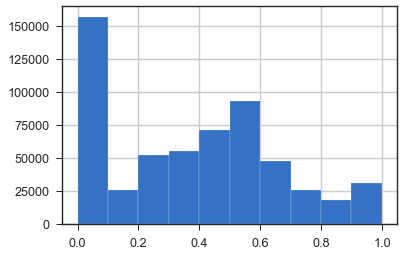

In [33]:
df.subjectivity_score.hist()

- **Look at the relationship between subjectivity and sentiment.**

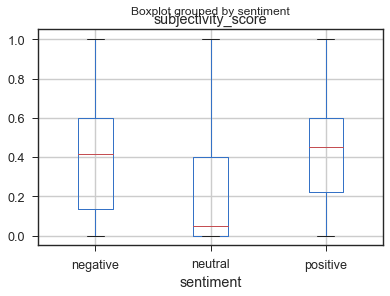

In [34]:
df.boxplot('subjectivity_score', 'sentiment')

- **As expected, neutral tweets tend to be more objective, whereas positive and negative tweets are more subjective.**

###### How about between subjectivity and LDA topics?

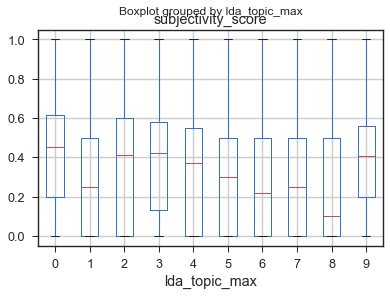

In [35]:
df.boxplot('subjectivity_score', 'lda_topic_max')

- **Some difference here but nothing too telling, given the generalness of LDA topics.**

###### Make sure our DataFrame has all the columns.

In [36]:
df.columns

Index(['date', 'tweet', 'username', 'link', 'nlikes', 'nreplies', 'nretweets',
       'sentiment_score', 'sentiment', 'clean_tweet', 'lda_topic_max', 'lda_0',
       'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8',
       'lda_9', 'subjectivity_score'],
      dtype='object')

- **Save for good measure, this time using pickle so we don't have to keep converting the date column.**
- **Also, some clean tweets are empty after removing stopwords, so this prevents them from being converted to NaNs.**

In [50]:
# # uncomment to save
# with gzip.open('data/5k_jan_thru_may_tweets_plus_features.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/5k_jan_thru_may_tweets_plus_features.pkl', 'rb') as hello:
#     df = pickle.load(hello)

# EDA
## Sentiment over time
### By day

In [ ]:
# proportion of sentiments by day
df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

In [ ]:
# proportion of sentiments by day
sent_by_day = df.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

# plot a stacked line graph
p1 = sent_by_day.plot.area(stacked=True, figsize=(20,12),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7)

# prettify the graph
p1.set_title('Tweet Sentiment Distribution Over Time', fontsize=30, pad=15)
p1.set_xlabel('Date', fontsize=28)
p1.set_ylabel('Percentage of Tweets', fontsize=28, labelpad=15)
p1.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=25)
plt.setp(p1.get_xticklabels(), fontsize=22)
plt.setp(p1.get_yticklabels(), fontsize=22);

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_stacked_line.png', bbox_inches='tight', transparent=True)

plt.show()

- **Tweets start off as overwhelming negative in the first half of January, though it should be noted that there are far fewer tweets from that time period, so this should be taken with a rather large grain of salt.**
- **Mid-February is another point of interest, with a large spike in negative tweets, perhaps corresponding to the first rumblings of COVID in the US.**
- **Negativity appears to gradually decrease until the end of April, which corresponds with a spike in Topic 7 (Trump and the social distancing protests), and negativity increases until the end of May.**
- **Positivity has its strongest moments in mid- to late-March, but stays fairly constant throughout.**
- **Overall, we don't see any overwhelming shift in sentiment, merely a fairly consistently polarized twitterverse.**

### Top tweets per day
- **See if the most popular tweets have a different distribution of sentiment over time.**

In [ ]:
# create dataframe of top twenty tweets per day by likes
top_20_by_day = []
for i in df.groupby('date')['nlikes'].nlargest(20).index:
    top_20_by_day.append(i[1])
    
top_20_by_day = df.loc[top_20_by_day]
top_20_by_day.shape

In [ ]:
# proportion of sentiments of top twenty tweets by day
sent_top_20_by_day = top_20_by_day.groupby('date')['sentiment'].value_counts(normalize=True).unstack()

# plot a stacked line graph
p2 = sent_top_20_by_day.plot.area(stacked=True, figsize=(20,12),
                                   color=['orangered', 'gold', 'forestgreen'], alpha=0.7)

# prettify the chart
p2.set_title('Sentiment of Daily Top Twenty Tweets', fontsize=30, pad=10)
p2.set_xlabel('Date', fontsize=28)
p2.set_ylabel('Percentage of Tweets', fontsize=28, labelpad=15)
p2.set_yticklabels(range(0,101,20), fontsize=22)
plt.setp(p2.get_xticklabels(), fontsize=22)
p2.legend(['Negative', 'Neutral', 'Positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=25)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_top20_stacked_line.png', bbox_inches='tight', transparent=True)

plt.show()

- **No obvious trends here, just a lot of noise back and forth.**
    - ***Maybe* skews positive toward the end, but both positive and negative again hover in the 40% range.**

### Month

In [ ]:
df['month'] = df.date.apply(lambda x: x.month)
df['month'].head()

In [ ]:
df.groupby('month').sentiment.value_counts(normalize=True)

In [ ]:
# prepare data for stacked bar, sort by percentage of trees in good health
month_sentiment = df.groupby('month').sentiment.value_counts(normalize=True).unstack()

# plot stacked bar graph
p3 = month_sentiment.plot(kind='bar', stacked=True, figsize=(8,6),
                           color=['orangered', 'gold', 'forestgreen'], alpha=0.7, fontsize=14)

# prettify the graph
p3.set_title('Distribution of Sentiment Over Time', fontsize=22, pad=10)
p3.set_xlabel('Month', fontsize=18, labelpad=10)
p3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May'], rotation='horizontal', fontsize=18)
p3.set_ylabel('Health Status', fontsize=18, labelpad=10)
p3.legend(['Negative', 'Neutral', 'Positive'], fontsize=18, bbox_to_anchor=(1,1))

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/sentiment_month_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- **Positive tweets gain a slight edge during March and April, but are generally fairly even.**
- **April stands out for having noticeably more neutral tweets, perhaps a result of wider news coverage.**

### Number of likes

In [ ]:
df.boxplot('nlikes', 'sentiment', showfliers=False)

In [ ]:
df[df.nlikes > 0].groupby('sentiment').tweet.count()

In [ ]:
df[df.nlikes > 0].boxplot('nlikes', 'sentiment', showfliers=False)

In [ ]:
df[df.nlikes > 10].groupby('sentiment')['tweet'].count()

In [ ]:
df[df.nlikes > 10].boxplot('nlikes', 'sentiment', showfliers=False)

- **Number of likes appears static across different sentiment.**


- **We'll next look at top words (after removing stop words and lemmatizing).**

## Top words and vocabulary statistics

In [ ]:
# make tweets into one big string
big_string = ' '.join(clean_tweets)
big_string[:100]

In [ ]:
# split it into words
words = big_string.split()

###### Number of words in our corpus

In [ ]:
len(words)

###### Total unique vocabulary

In [ ]:
total_vocab = set(words)
len(total_vocab)

- **Create a word list with corresponding frequencies in the corpus and look at the 25 most frequent words in our cleaned tweets.**

In [ ]:
Counter(words).most_common(25)

- **Create a similar object in dictionary format and convert to DataFrame.**

In [ ]:
fdist = FreqDist(words)
fdist

In [ ]:
word_counts = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
word_counts = word_counts.sort_values('word_count', ascending=False)
word_counts.head()

- **Take the top 25 words and create a visualization.**

In [ ]:
top25_words = word_counts.iloc[:25,:]

In [ ]:
# prettify the chart
plt.figure(figsize=(25,10))
plt.title('Top 25 Words', fontsize=30, pad=15)
plt.ylabel('Word Count', fontsize=28, labelpad=15)
plt.xticks(rotation=45, fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(bottom=15000, top=41000)

# plot bar chart with twitter blue ;)
plt.bar(top25_words.index, top25_words.word_count, color='#38A1F3')

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/top25_words_bar.png', bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
df.columns

In [ ]:
df.sentiment.head()

In [ ]:
plt.figure(figsize=(40,40))

sentiments = list(df.sentiment.unique())

for i, sentiment in enumerate(sentiments):
    # create a series of processed tweets
    sentiment_string_series = df[df.sentiment == sentiment].clean_tweet
    
    # convert the series to one big string
    sentiment_big_string = ' '.join(sentiment_string_series)
    
    # split the big string so we get all words in the category
    sentiment_words = sentiment_big_string.split()
    
    # create dictionary of word counts
    fdist = FreqDist(sentiment_words)
    
    # convert word counts to dataframe
    fdist_df = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
    fdist_df = fdist_df.sort_values('word_count', ascending=False)
    
    # look at the top 25 words for the genre
    top_25 = fdist_df.iloc[:25,:]

    # set dimension of plots
    nrows = 3
    ncols = 1
    plt.subplot(nrows, ncols, i+1)

    # list of colors
    colors = ['orangered', 'forestgreen', 'gold']
    
    # prettify
    plt.title(f'{sentiment.title()} -- Top 25 Words', fontsize=50, pad=15, x=0.5, y=0.9)
    plt.ylabel('Word Count', fontsize=40, labelpad=15)
    plt.xticks(rotation=70, fontsize=35)
    plt.yticks(fontsize=35)
    
    # plot
    plt.bar(top_25.index, top_25.word_count, color=colors[i])
    plt.tight_layout()
    
# # uncomment to save
# plt.savefig('charts/top25_words_each_sentiment_bar.png', bbox_inches='tight', transparent=True)

### Word Clouds

In [ ]:
# word cloud
word_dict = dict(Counter(words))
wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).generate_from_frequencies(word_dict)

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# save
plt.savefig('charts/word_cloud_all.png', bbox_inches='tight', transparent=True)

- **Now, we'll look at word clouds for each of the categories.**

In [ ]:
# instantiate a figure
plt.figure(figsize=(20,35))

# loop over sentiments list created earlier
for i, sentiment in enumerate(sentiments):
    
    # create a series of processed tweets
    sentiment_string_series = df[df.sentiment == sentiment].clean_tweet
    
    # convert the series to one big string
    sentiment_big_string = ' '.join(sentiment_string_series)
    
    # split the big string so we get all words in the category
    sentiment_words = sentiment_big_string.split()
    
    # create a dictionary for easy word cloud creation
    sentiment_word_dict = dict(Counter(sentiment_words))

    # create word cloud
    sentiment_wordcloud = WordCloud(colormap='Spectral', width=1200, height=600).\
                                                        generate_from_frequencies(sentiment_word_dict)

    # set dimension of plots
    nrows = 3
    ncols = 1

    # plot
    plt.subplot(nrows, ncols, i+1)
    plt.plot()
    plt.imshow(sentiment_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment.title()} Tweets', fontsize=50, pad=25)

# # uncomment to save
# plt.savefig('charts/word_cloud_each_sentiment.png', bbox_inches='tight', transparent=True)

## LDA
### Topic distribution by day

In [ ]:
# sort by percentage of trees in good health
days = df.groupby('date').lda_topic_max.value_counts(normalize=True).unstack()

# plot a stacked bar graph
p4 = days.plot.area(stacked=True, figsize=(16,9), alpha=0.7, fontsize=16)

# prettify the graph
p4.set_title('Topics Across Time', fontsize=25, pad=15)
p4.set_xlabel('Date', fontsize=22, labelpad=10)
p4.set_ylabel('Percentage of Tweets', fontsize=22, labelpad=10)
p4.set_yticklabels(range(0,101,20), fontsize=16)
p4.legend([f'lda_{i}' for i in range(10)], facecolor='white',
          framealpha=1, bbox_to_anchor=(1.01, 1.0), fontsize=18)

# prepare to save and display
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/topics_across_time_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- **Not the most readable graph, but does show some interesting activity around January 20 and the end of April.**

- **We'll now look at the relationship between sentiment and topics.**

### Sentiment distribution by topic

In [ ]:
# sort by percentage of topics in good health
days = df.groupby('lda_topic_max').sentiment.value_counts(normalize=True).unstack()

# plot a stacked bar graph
p5 = days.plot(kind='bar', stacked=True, figsize=(12,7), color=['orangered', 'gold', 'forestgreen'],
               alpha=0.7, fontsize=16)

# prettify the chart
p5.set_title('Tweet Sentiment by Topic', fontsize=20, pad=10)
p5.set_xlabel('LDA Topic', fontsize=18, labelpad=10)
p5.set_ylabel('Percentage of Tweets', fontsize=18, labelpad=10)
p5.set_xticklabels(range(10), rotation=0, fontsize=16)
p5.set_yticklabels(range(0,101,20), fontsize=16)
p5.legend(['negative', 'neutral', 'positive'], facecolor='white', framealpha=1,
          bbox_to_anchor=(1.01, 1.0), fontsize=16)

# prepare to save and display
plt.tight_layout()
# # uncomment to save 
# plt.savefig('charts/sentiment_topics_barstack.png', bbox_inches='tight', transparent=True)

plt.show()

- **Tweet topics have some definite affects on sentiment.**
    - **Topic 1 seems a bit strange to contain such a large amount of neutral tweets, something I assume mostly applies to news tweets, which makes sense for topic 6 (*news*, *study*, *claim*) and topic 8 (*data*, *nursing*).**
        - **Topic 1 has emojis, one of which is the generally ironic thinkingface and the other generally pro-mask.**
        - **Topic 8 does oddly contain *hoax* though this may be in relation to a news story reporting people's feelings toward COVID.**
    - **Topic 9 has a lot of negative tweets, which seems to make sense, discussing things like trump, death, social distancing (viewed negatively by some).**
    - **Topic 3 has the most positive tweets, which also seems to make sense, given words like *protect*, *help*, *others*, etc. It appears to be about the common good and using masks to help keep others safe.**
    - **Topic 7 interestingly has about equal numbers for all sentiment categories, and it does indeed seem to be the most polarizing of topics.**
    - **Topics 0 and 9 are relatively non-neutral.**

In [ ]:
lda.print_topics()

### Another look at sentiment distribution by topic

In [ ]:
# instantiate a figure
plt.figure(figsize=(12,24))

# loop over sentiments list created earlier
for i, sentiment in enumerate(sentiments):
    
    sentiment_df = df[df.sentiment == sentiment]

    # set dimension of plots
    nrows = 3
    ncols = 1
    plt.subplot(nrows, ncols, i+1)

    # list of colors
    colors = ['orangered', 'forestgreen', 'gold']
    
    # prettify chart
    plt.title(f'Number of {sentiment.title()} Tweets by Topic', fontsize=28, pad=15)
    plt.xlabel('LDA Topic Number', fontsize=22, labelpad=15)
    plt.ylabel('Tweet Count', fontsize=24, labelpad=15)
    plt.xticks(range(10), rotation=0, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(bottom=0, top=70000)
    
    # plot, making sure to sort the labels so they go in sequential order
    plt.bar(sentiment_df.lda_topic_max.value_counts().sort_index().index,
            sentiment_df.lda_topic_max.value_counts().sort_index(), 
            color=colors[i])
    plt.tight_layout(pad=5)
    
# # uncomment to save
# plt.savefig('charts/sentiment_topics_each_sentiment_barstack.png', bbox_inches='tight', transparent=True)

- **This gives you a little more sense of how similarly sentiment is distributed across topics, with the shapes of these bars more or less the same across the three categories.**
- **Some notable exceptions:**
    - **Topic 5 has a large relative share of neutral tweets.**
    - **Topic 3 has a large relative share of positive tweets.**
    - **Topic 9 has a large relative share of negative tweets.**
    - **Topics 1, 6, and 7 are pretty evenly split amongst the three categories.**
    
### LDA with numerical data
- **We'll look at number of likes, replies, and retweets across the topics.**

In [ ]:
df[df.nlikes > 10].boxplot('nlikes', 'lda_topic_max', showfliers=False)

In [ ]:
df[df.nreplies > 10].boxplot('nreplies', 'lda_topic_max', showfliers=False)

In [ ]:
df[df.nretweets > 10].boxplot('nretweets', 'lda_topic_max', showfliers=False)

- **No standout topics here.**